<a href="https://colab.research.google.com/github/AroraAnshul301/Chat-App/blob/main/try.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from pathlib import Path
from PIL import Image

hazy_images_path="/content/drive/MyDrive/UIEB/raw"
orig_images_path="/content/drive/MyDrive/UIEB/reference"

In [ ]:
import os
import sys

import torch
import torch.utils.data as data

import numpy as np
from PIL import Image
import glob
import random
import cv2

random.seed(42)


def populate_train_list(orig_images_path, hazy_images_path):
    import glob
    import random

    train_list = []
    val_list = []

    image_list_haze = glob.glob((hazy_images_path) + "/*.png")

    tmp_dict = {}

    for image in image_list_haze:
        image = image.split("/")[-1]
        key = image


        if key in tmp_dict.keys():
            tmp_dict[key].append(image)
        else:
            tmp_dict[key] = []
            tmp_dict[key].append(image)

    train_keys = []
    val_keys = []

    len_keys = len(tmp_dict.keys())
    for i in range(len_keys):
        if i < len_keys * 9 / 10:
            train_keys.append(list(tmp_dict.keys())[i])
        else:
            val_keys.append(list(tmp_dict.keys())[i])

    for key in list(tmp_dict.keys()):

        if key in train_keys:
            for hazy_image in tmp_dict[key]:
                train_list.append([str(orig_images_path) + "/" + key, str(hazy_images_path) + "/" + hazy_image])

        else:
            for hazy_image in tmp_dict[key]:
                val_list.append([str(orig_images_path) + "/" + key, str(hazy_images_path) + "/" + hazy_image])

    random.shuffle(train_list)
    random.shuffle(val_list)

    return train_list, val_list

In [ ]:
train_list,val_list=populate_train_list(orig_images_path, hazy_images_path)
len(train_list),len(val_list)


(801, 89)

In [ ]:
class dehazing_loader(data.Dataset):

	def __init__(self, orig_images_path, hazy_images_path, mode='train'):

		self.train_list, self.val_list = populate_train_list(orig_images_path, hazy_images_path)

		if mode == 'train':
			self.data_list = self.train_list
			print("Total training examples:", len(self.train_list))
		else:
			self.data_list = self.val_list
			print("Total validation examples:", len(self.val_list))



	def __getitem__(self, index):

		data_orig_path, data_hazy_path = self.data_list[index]

		data_orig = Image.open(data_orig_path)
		data_hazy = Image.open(data_hazy_path)

		data_orig = data_orig.resize((480,640), Image.Resampling.LANCZOS)
		data_hazy = data_hazy.resize((480,640), Image.Resampling.LANCZOS)

		data_orig = (np.asarray(data_orig)/255.0)
		data_hazy = (np.asarray(data_hazy)/255.0)

		data_orig = torch.from_numpy(data_orig).float()
		data_hazy = torch.from_numpy(data_hazy).float()

		return data_orig.permute(2,0,1), data_hazy.permute(2,0,1)

	def __len__(self):
		return len(self.data_list)

In [ ]:
train_dataset=dehazing_loader(orig_images_path, hazy_images_path, mode='train')
val_dataset=dehazing_loader(orig_images_path, hazy_images_path, mode='val')

true,raw=train_dataset[0]
true.shape,raw.shape

Total training examples: 801
Total validation examples: 89


(torch.Size([3, 640, 480]), torch.Size([3, 640, 480]))

In [ ]:
train_loader=torch.utils.data.DataLoader(train_dataset,batch_size=8,shuffle=True)
val_loader=torch.utils.data.DataLoader(val_dataset,batch_size=8,shuffle=True)
len(train_loader),len(val_loader)

(101, 12)

In [ ]:
import torch
import torch.nn as nn
import math

class dehaze_net(nn.Module):

	def __init__(self):
		super(dehaze_net, self).__init__()

		self.relu = nn.ReLU(inplace=True)

		self.e_conv1 = nn.Conv2d(3,3,1,1,0,bias=True)
		self.e_conv2 = nn.Conv2d(3,3,3,1,1,bias=True)
		self.e_conv3 = nn.Conv2d(6,3,5,1,2,bias=True)
		self.e_conv4 = nn.Conv2d(6,3,7,1,3,bias=True)
		self.e_conv5 = nn.Conv2d(12,3,3,1,1,bias=True)

	def forward(self, x):
		source = []
		source.append(x)

		x1 = self.relu(self.e_conv1(x))
		x2 = self.relu(self.e_conv2(x1))

		concat1 = torch.cat((x1,x2), 1)
		x3 = self.relu(self.e_conv3(concat1))

		concat2 = torch.cat((x2, x3), 1)
		x4 = self.relu(self.e_conv4(concat2))

		concat3 = torch.cat((x1,x2,x3,x4),1)
		x5 = self.relu(self.e_conv5(concat3))

		clean_image = self.relu((x5 * x) - x5 + 1)

		return clean_image

In [ ]:
device="cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_0=dehaze_net().to(device)
model_0

dehaze_net(
  (relu): ReLU(inplace=True)
  (e_conv1): Conv2d(3, 3, kernel_size=(1, 1), stride=(1, 1))
  (e_conv2): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e_conv3): Conv2d(6, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (e_conv4): Conv2d(6, 3, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (e_conv5): Conv2d(12, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [ ]:
model_0.apply(weights_init)

dehaze_net(
  (relu): ReLU(inplace=True)
  (e_conv1): Conv2d(3, 3, kernel_size=(1, 1), stride=(1, 1))
  (e_conv2): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e_conv3): Conv2d(6, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (e_conv4): Conv2d(6, 3, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (e_conv5): Conv2d(12, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [ ]:
from torch import nn

loss_fn=nn.MSELoss()
optimizer=torch.optim.Adam(model_0.parameters(),lr=0.0001,weight_decay=0.0001)

In [ ]:
import torch
from tqdm.auto import tqdm
import torchvision


torch.manual_seed(42)
torch.cuda.manual_seed(42)


epochs=50


for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n----------")
  train_loss=0
  for iteration,(img_orig,img_haze) in enumerate(train_loader):
    model_0.train()
    img_orig=img_orig.to(device)
    img_haze=img_haze.to(device)

    clean_image=model_0(img_haze)
    loss=loss_fn(clean_image,img_orig)
    train_loss+=loss.item()

    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm(model_0.parameters(),0.1)
    optimizer.step()


  train_loss/=len(train_loader)
  print(f"Train Loss: {train_loss:.4f}")

  ## Validating
  test_loss=0
  model_0.eval()
  with torch.inference_mode():
    for iter_val,(img_orig,img_haze) in enumerate(val_loader):
      img_orig=img_orig.to(device)
      img_haze=img_haze.to(device)
      clean_image=model_0(img_haze)
      test_loss+=loss_fn(clean_image,img_orig).item()


  test_loss/=len(val_loader)
  print(f"Test loss: {test_loss:.5f}")




  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0
----------


<ipython-input-39-974cc91f823b>:27: FutureWarning: `torch.nn.utils.clip_grad_norm` is now deprecated in favor of `torch.nn.utils.clip_grad_norm_`.
  torch.nn.utils.clip_grad_norm(model_0.parameters(),0.1)


Train Loss: 0.2900
Test loss: 0.18946
Epoch: 1
----------
Train Loss: 0.1428
Test loss: 0.12660
Epoch: 2
----------
Train Loss: 0.1300
Test loss: 0.12611
Epoch: 3
----------
Train Loss: 0.1303
Test loss: 0.12578
Epoch: 4
----------
Train Loss: 0.1296
Test loss: 0.12198
Epoch: 5
----------
Train Loss: 0.1301
Test loss: 0.11850
Epoch: 6
----------
Train Loss: 0.1295
Test loss: 0.12355
Epoch: 7
----------
Train Loss: 0.1298
Test loss: 0.11826
Epoch: 8
----------
Train Loss: 0.1301
Test loss: 0.12109
Epoch: 9
----------
Train Loss: 0.1290
Test loss: 0.11980
Epoch: 10
----------
Train Loss: 0.1295
Test loss: 0.12997
Epoch: 11
----------
Train Loss: 0.1289
Test loss: 0.11824
Epoch: 12
----------
Train Loss: 0.1286
Test loss: 0.12702
Epoch: 13
----------
Train Loss: 0.1295
Test loss: 0.11806
Epoch: 14
----------
Train Loss: 0.1289
Test loss: 0.12664
Epoch: 15
----------
Train Loss: 0.1292
Test loss: 0.12024
Epoch: 16
----------
Train Loss: 0.1292
Test loss: 0.12022
Epoch: 17
----------
Train 

In [ ]:
# torch.save(model_0.state_dict(),"/content/drive/MyDrive/dehazing_model.pth")

In [ ]:
model_1=dehaze_net().to(device)
model_1.load_state_dict(torch.load("/content/drive/MyDrive/dehazing_model.pth", map_location=torch.device('cpu')))

<All keys matched successfully>

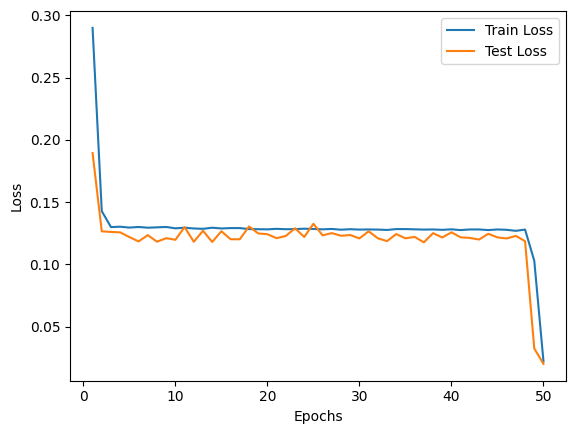

In [ ]:
import matplotlib.pyplot as plt
epochs=torch.arange(1,51)
train_loss = [
    0.2900, 0.1428, 0.1300, 0.1303, 0.1296, 0.1301, 0.1295, 0.1298, 0.1301, 0.1290,
    0.1295, 0.1289, 0.1286, 0.1295, 0.1289, 0.1292, 0.1292, 0.1284, 0.1283, 0.1282,
    0.1286, 0.1283, 0.1284, 0.1287, 0.1285, 0.1282, 0.1285, 0.1279, 0.1283, 0.1280,
    0.1281, 0.1280, 0.1277, 0.1284, 0.1284, 0.1282, 0.1280, 0.1281, 0.1278, 0.1282,
    0.1276, 0.1281, 0.1281, 0.1276, 0.1281, 0.1278, 0.1270, 0.1280, 0.1029, 0.0221
]
test_loss = [
    0.18946, 0.12660, 0.12611, 0.12578, 0.12198, 0.11850, 0.12355, 0.11826, 0.12109, 0.11980,
    0.12997, 0.11824, 0.12702, 0.11806, 0.12664, 0.12024, 0.12022, 0.13054, 0.12490, 0.12427,
    0.12109, 0.12287, 0.12907, 0.12209, 0.13265, 0.12337, 0.12516, 0.12303, 0.12363, 0.12091,
    0.12661, 0.12101, 0.11874, 0.12440, 0.12098, 0.12213, 0.11774, 0.12513, 0.12165, 0.12580,
    0.12180, 0.12131, 0.12000, 0.12463, 0.12172, 0.12088, 0.12293, 0.11869, 0.03247, 0.02008
]


fig=plt.plot(fig_size=(9,9))
plt.plot(epochs,train_loss,label="Train Loss")
plt.plot(epochs,test_loss,label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

In [ ]:
!pip install torchmetrics

In [ ]:
from torchmetrics.image import PeakSignalNoiseRatio,StructuralSimilarityIndexMeasure
psnr = PeakSignalNoiseRatio().to(device)
ssim = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)

In [ ]:
def evaluate_model(model:nn.Module,data_loader:torch.utils.data.DataLoader,loss_fn):
  model.eval()
  with torch.inference_mode():
    test_loss=0
    psnr_loss=0
    ssim_loss=0
    for iter_val,(img_orig,img_haze) in enumerate(val_loader):
      img_orig=img_orig.to(device)
      img_haze=img_haze.to(device)
      clean_image=model_0(img_haze)
      test_loss+=loss_fn(clean_image,img_orig).item()
      psnr_loss+=psnr(clean_image,img_orig).item()
      ssim_loss+=ssim(clean_image,img_orig).item()

    test_loss/=len(data_loader)
    psnr_loss/=len(data_loader)
    ssim_loss/=len(data_loader)
    return {"model_name":model.__class__.__name__,"model_loss_mse":test_loss,"model_loss_psnr":psnr_loss,"model_loss_ssim":ssim_loss}


evaluate_model(model=model_1,data_loader=val_loader,loss_fn=loss_fn)